## **Importação das bibliotecas e carregamento do Dataframe**

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

In [44]:
import random
#Mudar a path da base de dados 
path = r"DataBases\Diamonds_values_faltantes.csv"
diamonds = pd.read_csv(fr"{path}")

diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,NaN,61.2,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,NaN,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,62.5,57.0,2757.0,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757.0,5.69,5.75,3.61
53937,0.70,NaN,D,SI1,62.8,60.0,2757.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757.0,6.15,6.12,3.74


# **Visualização de coeficiênte de correlação linear e separação da base de dados, para melhor implementação do KNN.**

Abaixo está a quantidade de valores faltantes por coluna

In [45]:
counter = {}
for x in range(diamonds.shape[1]):
    column_name = diamonds.columns[x]
    counter[column_name] = diamonds.shape[0] - len(diamonds[column_name].dropna())

counter_df = pd.DataFrame(list(counter.items()), columns=['Coluna', 'Quantidade de NaN'])
counter_df

,Coluna,Quantidade de NaN
0,carat,1649
1,cut,1556
2,color,1540
3,clarity,1476
4,depth,1421
5,table,1369
6,price,1340
7,x,1308
8,y,1253
9,z,1257


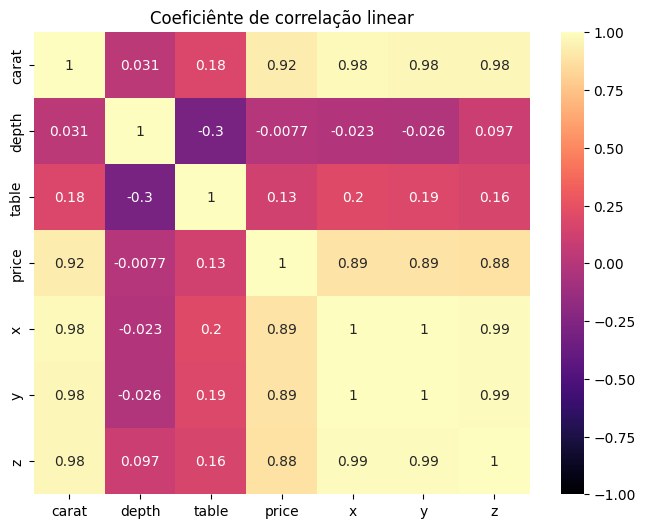

In [46]:
plt.figure(figsize = (8, 6))
sns.heatmap((diamonds[["carat", "depth", "table", "price", "x", "y", "z"]]).corr(), vmin = -1, vmax = 1, annot = True, cmap = 'magma')
plt.title("Coeficiênte de correlação linear")
plt.show()

**Análise do heatmap acima com base no price(preço):**
- Podemos concluir que o price(preço) não tem uma correlação boa com a porcentagem total do diamante(depth) e também não tem uma correlação alta com o table, sendo uma correlação inversamente proporcional de -0,0086 com o depth, e uma relação proporcional de 0,13 com o table.
- Podemos concluir também que o preço tem uma boa correlação linear com o carat(quilate) de 0,92, x(comprimento) de 0,89, y(largura) de 0,89 e z(profundidade) de 0,88.

Com base nessa análise do heatmap, podemos concluir que quanto maior o carat(quilate), x(comprimento), y(largura) e z(profundidade), maior poderá ser o price(preço) do diamante.

Entretato, podem existir alguns casos, de se ter um diamante com um quilate muito alto porém com um preço baixo, assim como poderá existir diamantes com um quilate baixo mas com um preço alto. Tal, poderá também acontecer com o x(comprimento), y(largura) e z(profundidade), por causa disso nos questionamos o seguinte, quanto que o carat(quilate), x(comprimento), y(largura) e z(profundidade) conseguem determinar o valor do diamante? Para responder isso, precisamos tirar o Coeficiênte de Determinação.

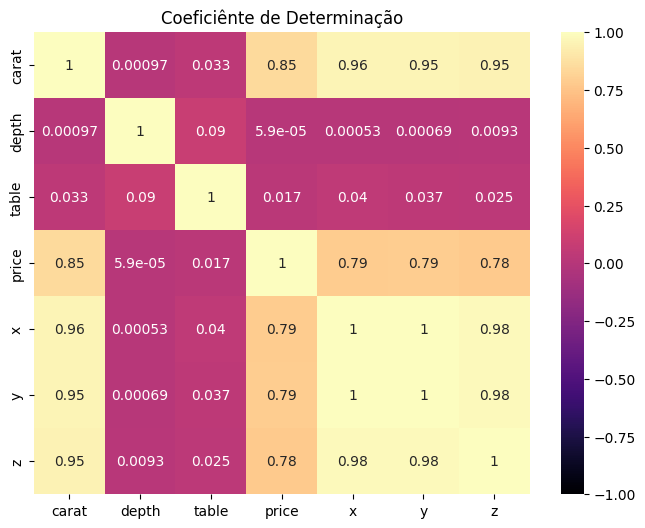

In [47]:
plt.figure(figsize = (8, 6))
sns.heatmap((diamonds[["carat", "depth", "table", "price", "x", "y", "z"]]).corr()**2, vmin = -1, vmax = 1, annot = True, cmap = 'magma')
plt.title("Coeficiênte de Determinação")
plt.show()

**Análise do heatmap acima com base no price(preço):**

Ao analisarmos o heatmap acima, podemos perceber que podemos definir o preço do diamante com maior confiabilidade usando a variável numérica carat(quilate), com confiabilidade de 85%, isso significa que por mais que possamos dizer que quanto maior o quilate do diamante maior o seu preço, infelizmente essa regra só é de fato válida para 85% dos dados.

Já para x(comprimento), y(largura) e z(profundidade), essa confiabilidade é de apenas 79% para comprimento e largura, e 78% para profundidade, o que não é uma determinação forte, e por isso poderão ser desconsideradas caso as variáveis categóricas, consigam definir com precisão o preço do diamante.

Abaixo estamos realizando o processo de separação da base de dados diamonds. Para que assim, o processo de machine learn seja mais efetivo.

- Cut tem 5 tipos de classificação Ideal, Premium, Good, Very Good e Fair

- Color tem 7 tipos de classificação E, I, J, H, F, G e D

- Clarity tem 8 tipos de classificação SI2, SI1, VS1, VS2, VVS2, VVS1, I1 e IF

# **Implementação do K-NN**

Colocando medições iguais a 0 de comprimento, largura e/ou profundidade de um diamante como NaN

In [48]:
for x in range(diamonds.shape[0]):
    for y in range(7, diamonds.shape[1]):
        if diamonds.iloc[x, y] == 0: diamonds.iloc[x, y] = np.nan
        elif diamonds.iloc[x, y] >= 30: diamonds.iloc[x, y] = np.nan
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,NaN,61.2,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,NaN,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,62.5,57.0,2757.0,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757.0,5.69,5.75,3.61
53937,0.70,NaN,D,SI1,62.8,60.0,2757.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757.0,6.15,6.12,3.74


Abaixo está a implementação do K-NN nas colunas numéricas

In [49]:
'''Algumas livros aconselham usar a formula (K = log n) onde n é o numero de linhas da base de dados.
Para assim definir a quantidade de K.'''

classificacao = KNNImputer(n_neighbors = round(math.log(diamonds.shape[0])))
diamonds[["carat", "depth", "table", "price", "x", "y", "z"]] = classificacao.fit_transform(diamonds[["carat", "depth", "table", "price", "x", "y", "z"]])

diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.950000,3.98,2.43
1,0.21,Premium,E,NaN,61.2,61.0,326.0,3.890000,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.050000,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.362727,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.340000,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,62.5,57.0,2757.0,5.750000,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757.0,5.690000,5.75,3.61
53937,0.70,NaN,D,SI1,62.8,60.0,2757.0,5.660000,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757.0,6.150000,6.12,3.74


Aplicação do K-NN para colunas categóricas

In [50]:
'''KNN para valores categóricos'''
encoder = OrdinalEncoder()
diamonds_encoder = encoder.fit_transform(diamonds)

knn_imputer = KNNImputer(n_neighbors = round(math.log(diamonds.shape[0])))
diamonds_imputer = knn_imputer.fit_transform(diamonds_encoder)


diamonds_imputer = pd.DataFrame(diamonds_imputer, columns = diamonds.columns)
diamonds_imputer = encoder.inverse_transform(diamonds_imputer)

# Substituindo os valores faltantes na base de dados diamonds principal
for x in range(diamonds.shape[0]):
    for y in range(1, 4):
        if pd.isna(diamonds.iloc[x, y]): diamonds.iloc[x, y] = diamonds_imputer[x][y]

diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.950000,3.98,2.43
1,0.21,Premium,E,VS1,61.2,61.0,326.0,3.890000,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.050000,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.362727,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.340000,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,62.5,57.0,2757.0,5.750000,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757.0,5.690000,5.75,3.61
53937,0.70,Premium,D,SI1,62.8,60.0,2757.0,5.660000,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757.0,6.150000,6.12,3.74


Abaixo estamos normalizando as colunas numéricas.

In [51]:
#padronização das colunas numéricas
diamonds[["carat", "x", "y", "z"]] = round(diamonds[["carat", "x", "y", "z"]], 2)
diamonds[["table", "price"]] = round(diamonds[["table", "price"]])
diamonds["depth"] = round(diamonds["depth"], 1)

diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326.0,3.95,3.98,2.43
1,0.21,Premium,E,VS1,61.2,61.0,326.0,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327.0,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334.0,4.36,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,62.5,57.0,2757.0,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757.0,5.69,5.75,3.61
53937,0.70,Premium,D,SI1,62.8,60.0,2757.0,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757.0,6.15,6.12,3.74


Salvando a base de dados já limpa e sem valores faltantes

In [52]:
path = r"DataBases\Diamonds_limpa.csv"
try:
    pd.read_csv(f"{path}")
    print(f"Já existe esse dataframe no diretório: {path}")
except FileNotFoundError:
    diamonds.to_csv(fr"{path}", index = False)
    print(f'''Base de dados limpa adicionada ao diretório:
          {path}
          com sucesso!!''')


Já existe esse dataframe no diretório: DataBases\Diamonds_limpa.csv


# Análise da relação de preço das colunas numéricas

**INFORMAÇÕES IMPORTANTES:**
- 1 Quilate equivale a 200mg
- 1 Ponto equivale a 0,01 quilates

O gráfico abaixo compara a relação do comprimento de um diamante com o carat e com o preço

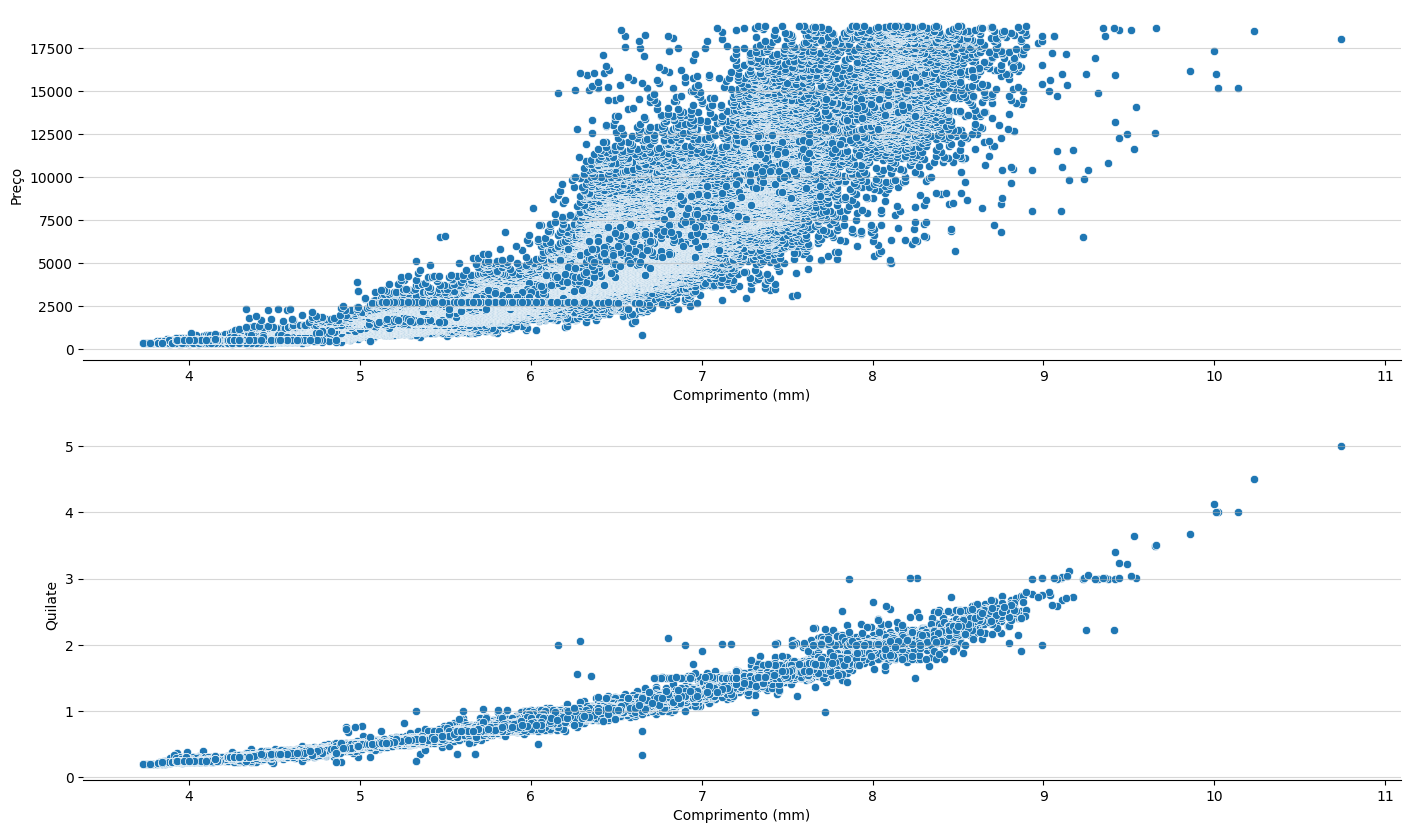

In [53]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
sns.scatterplot(data=diamonds, x = "x", y = "price")
plt.xlabel("Comprimento (mm)")
plt.ylabel("Preço")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.subplot(2, 1, 2)
sns.scatterplot(data=diamonds, x = "x", y = "carat")
plt.xlabel("Comprimento (mm)")
plt.ylabel("Quilate")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.show()

O gráfico abaixo compara a relação da largura de um diamante com o carat e com o preço

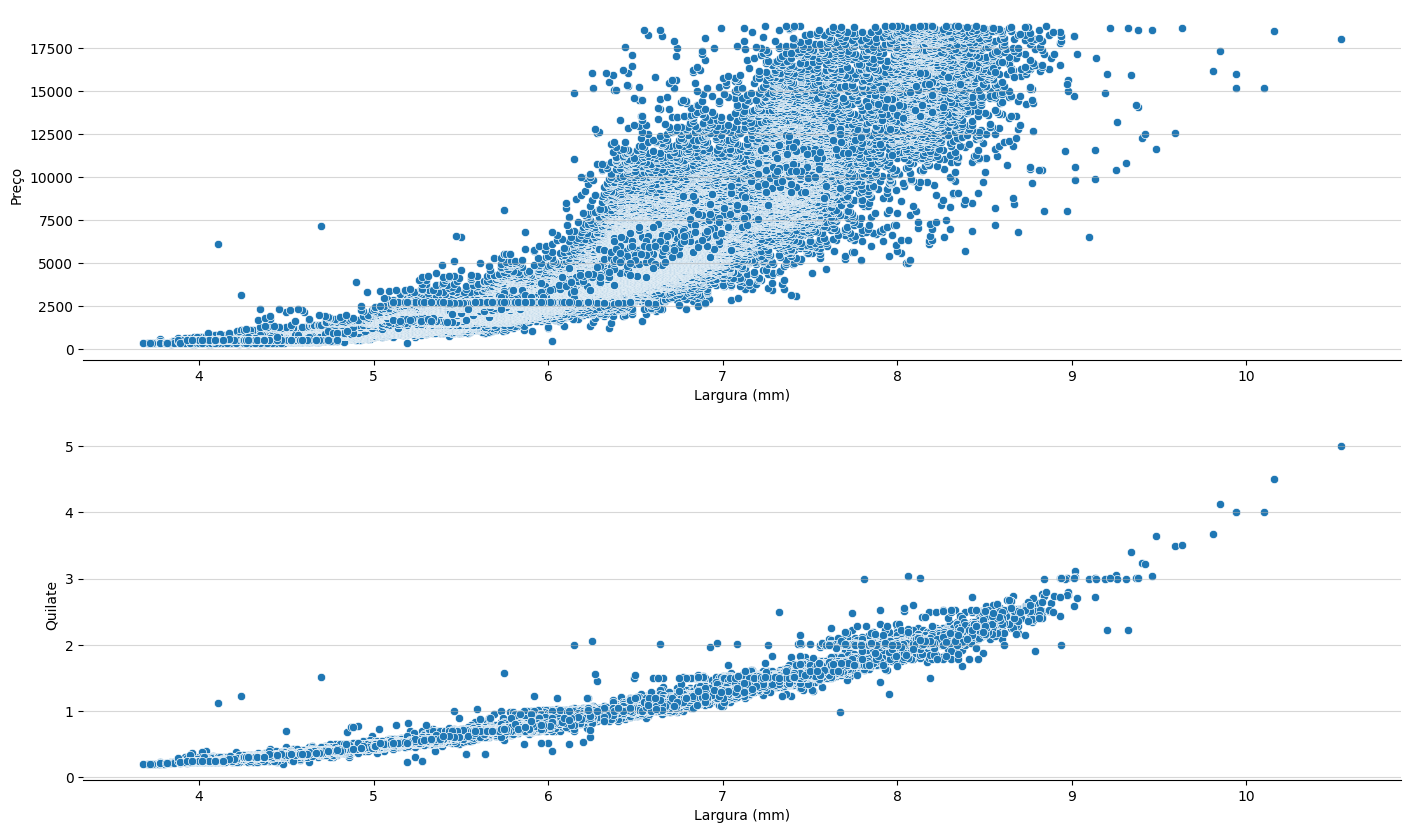

In [54]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
sns.scatterplot(diamonds, x = "y", y = "price")
plt.xlabel("Largura (mm)")
plt.ylabel("Preço")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.subplot(2, 1, 2)
sns.scatterplot(diamonds, x = "y", y = "carat")

plt.xlabel("Largura (mm)")
plt.ylabel("Quilate")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.show()

O gráfico abaixo compara a relação da profundidade de um diamante com o carat e com o preço

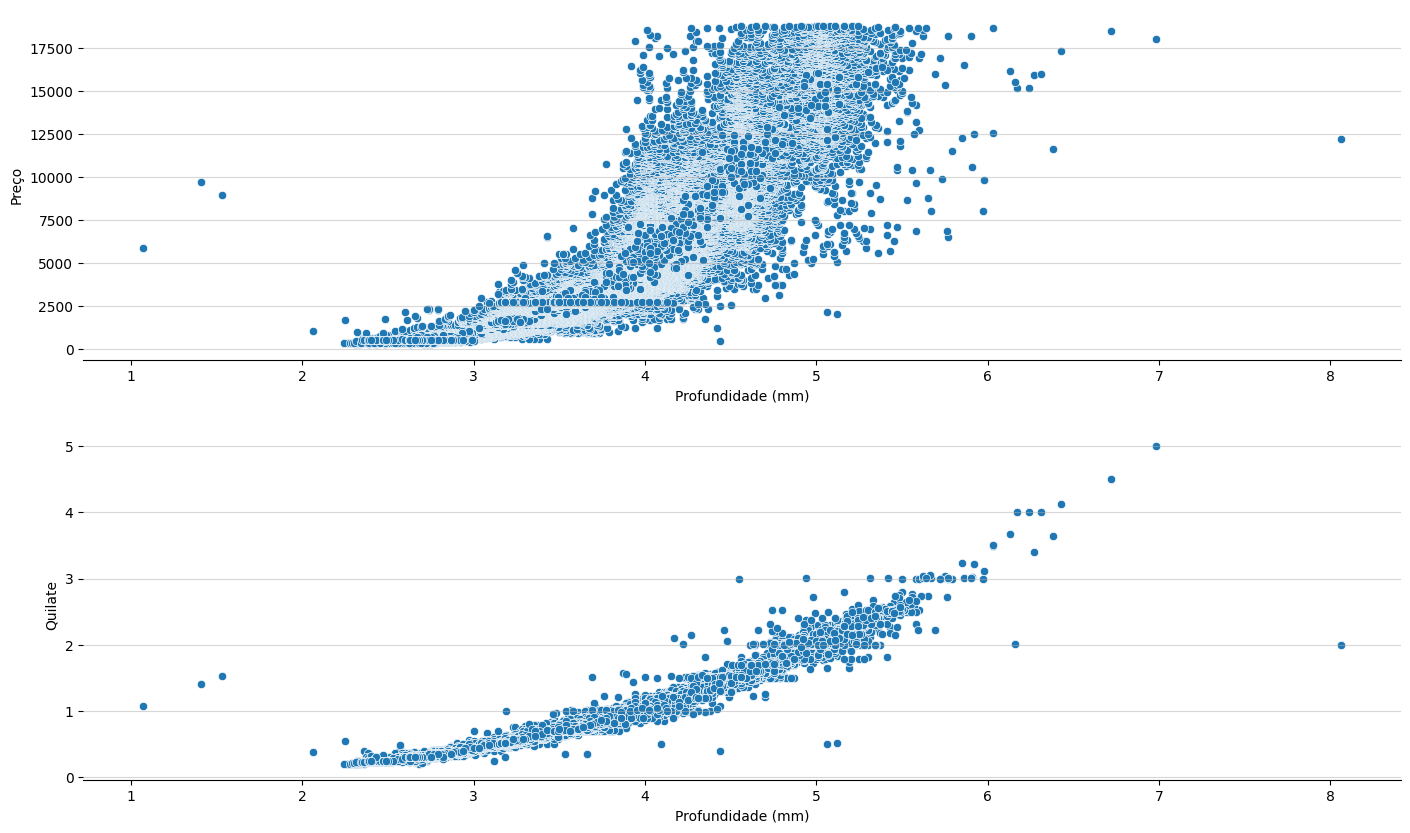

In [55]:
plt.figure(figsize=(17, 10))

plt.subplot(2, 1, 1)
sns.scatterplot(diamonds, x = "z", y = "price")
plt.xlabel("Profundidade (mm)")
plt.ylabel("Preço")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.subplot(2, 1, 2)
sns.scatterplot(diamonds, x = "z", y = "carat")
plt.xlabel("Profundidade (mm)")
plt.ylabel("Quilate")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.show()

O gráfico abaixo compara a relação do quilate de um diamante com o preço

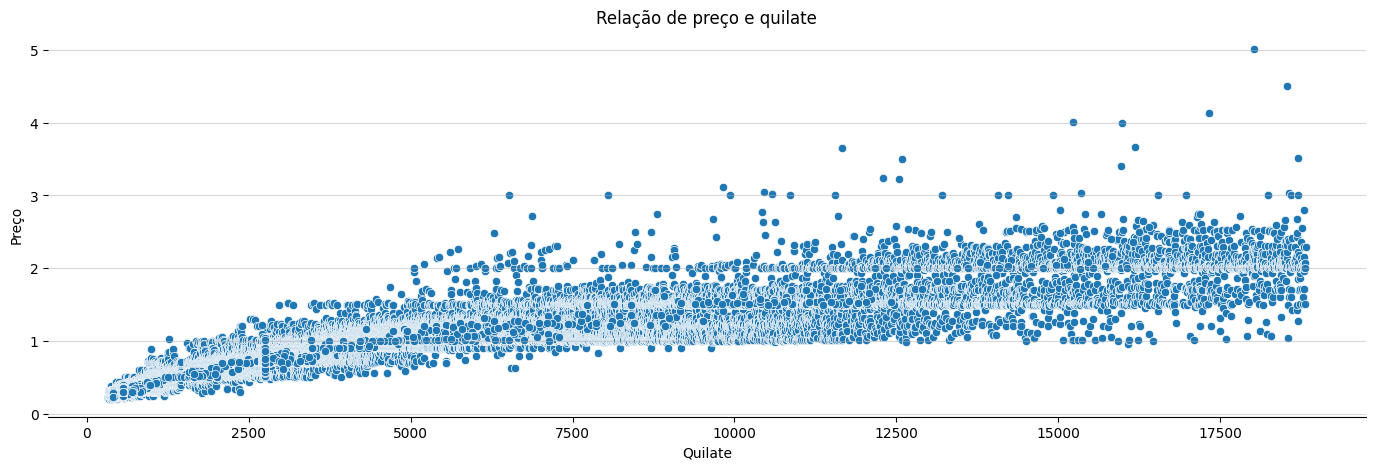

In [82]:
plt.figure(figsize=(17, 5))
sns.scatterplot(diamonds, x = "price", y = "carat")
plt.xlabel("Quilate")
plt.ylabel("Preço")
plt.title("Relação de preço e quilate")
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.grid(axis = "y", alpha = 0.5)

plt.show()

Com base nos gráficos apresentados, é evidente que o comprimento, largura e profundidade de um diamante têm uma relação mais confiável com seu peso em quilates do que com seu preço. Portanto, ao determinar o valor de um diamante com o mínimo de medidas necessárias, podemos confiar nos dados de quilates fornecidos. As dimensões físicas, como comprimento, largura e profundidade, oferecem uma indicação mais precisa do peso do diamante do que do seu valor monetário.

Entretanto, é importante ressaltar que isso não significa que não podemos usar as medidas de comprimento, largura e profundidade para estimar o valor de um diamante. Pelo contrário, quanto mais informações tivermos, mais precisa será a estimativa do preço do diamante. No entanto, se tivermos que escolher o mínimo de informações para estimar o valor de um diamante, podemos afirmar que o quilate é suficiente para essa avaliação.

#### **Existem 2 formar de estimar o quilate do diamante para o usuário do programa:**
1) Solicitar a massa do diamante para o cliente, e com isso realizar o cálculo:   
$$ \text{Quilate} = \frac{\text{Massa (mg)}}{200}$$

2) Para a segunda forma de estimar o quilate do diamante, é necessário 4 coisas: Comprimento (mm), Largura (mm), Profundidade (mm) e densidade ($\frac{mm}{mm³}$). Com isso utilizaremos o cálculo da densidade de um objeto, para assim cálcular primeiramante a massa do diamante: $$Densidade = \frac{Massa}{Volume} \rightarrow Massa = Densidade \times Volume $$ Entretanto temos um problema, não temos o volume do diamante, entretanto para isso, iremos dismenbrar o cálculo do volume de um objeto, sendo: $$Volume = Comprimento \times Largura \times Profundidade$$ Substituindo na fórmula então, ficará: $$Massa = Comprimento \times Largura \times Profundidade \times Densidade$$ Agora teremos de descobrir o quilate do diamante, para isso, usaremos a forma 1 de estimar o cálculo do diamante: $$Quilate = \frac{Massa (mg)}{200}$$ Ficando na fórmula geral: $$Quilate = \frac{Comprimento \times Largura \times Profundidade \times Densidade}{200} $$

# Relação de preço com as colunas categóricas

In [57]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797211,61.751344,57.452614,3933.400501,5.730429,5.732533,3.539051
std,0.472253,1.402362,2.198344,3979.171831,1.116350,1.108490,0.690327
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.100000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2409.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5366.000000,6.540000,6.540000,4.030000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,10.540000,8.060000


In [58]:
description = diamonds.describe()
price = [f"until ${description["price"]["25%"]}", 
    f"until ${description["price"]["50%"]}",
    f"until ${description["price"]["75%"]}",
    f"greater than ${description["price"]["75%"]}"]

carat = [f"until ${description["carat"]["25%"]}", 
    f"until ${description["carat"]["50%"]}",
    f"until ${description["carat"]["75%"]}",
    f"greater than ${description["carat"]["75%"]}"]

def agrupamento(diamonds, coluna, index_coluna: list):
    description = diamonds.describe()
    cut = pd.DataFrame({"Fair": [0.0 for x in range(4)],
                        "Good": [0.0 for x in range(4)],
                        "Very Good": [0.0 for x in range(4)],
                        "Premium": [0.0 for x in range(4)],
                        "Ideal": [0.0 for x in range(4)]}, 
                        index = index_coluna)

    color = pd.DataFrame({"J": [0.0 for x in range(4)],
                        "D": [0.0 for x in range(4)],
                        "I": [0.0 for x in range(4)],
                        "E": [0.0 for x in range(4)],
                        "F": [0.0 for x in range(4)],
                        "H": [0.0 for x in range(4)],
                        "G": [0.0 for x in range(4)]}, 
                        index = index_coluna)

    clarity = pd.DataFrame({"I1": [0.0 for x in range(4)],
                            "IF": [0.0 for x in range(4)],
                            "VVS1": [0.0 for x in range(4)],
                            "VVS2": [0.0 for x in range(4)],
                            "VS1": [0.0 for x in range(4)],
                            "VS2": [0.0 for x in range(4)],
                            "SI2": [0.0 for x in range(4)],
                            "SI1": [0.0 for x in range(4)]}, 
                            index = index_coluna)

    for intervalo in ["25%", "50%", "75%", "max"]:
        if intervalo == "25%":
            diamonds_aux = diamonds[diamonds[coluna] <= diamonds.describe()[coluna][intervalo]].reset_index()
            
        elif intervalo == "50%":
            diamonds_aux = diamonds[diamonds[coluna] > diamonds.describe()[coluna]["25%"]].reset_index()
            diamonds_aux = diamonds_aux[diamonds_aux[coluna] <= diamonds.describe()[coluna][intervalo]].reset_index()
            
        elif intervalo == "75%":
            diamonds_aux = diamonds[diamonds[coluna] > diamonds.describe()[coluna]["50%"]].reset_index()
            diamonds_aux = diamonds_aux[diamonds_aux[coluna] <= diamonds.describe()[coluna][intervalo]].reset_index()
            
        else:
            diamonds_aux = diamonds[diamonds[coluna] > diamonds.describe()[coluna]["75%"]].reset_index()
        
        describe = diamonds.describe()[coluna][intervalo]
        
        for x in range(diamonds_aux.shape[0]):
            for y in range(cut.shape[1]):
                if diamonds_aux.loc[x, "cut"] == cut.columns[y]:
                    try:
                        cut.loc[f"until ${describe}", cut.columns[y]] += 1.0
                    except KeyError:
                        cut.loc[f"greater than ${description[coluna]["75%"]}", cut.columns[y]] += 1.0
                    break
                
            for y in range(color.shape[1]):
                if diamonds_aux.loc[x, "color"] == color.columns[y]:
                    try:
                        color.loc[f"until ${describe}", color.columns[y]] += 1.0
                    except KeyError:
                        color.loc[f"greater than ${description[coluna]["75%"]}", color.columns[y]] += 1.0
                    break
                
            for y in range(clarity.shape[1]):
                if diamonds_aux.loc[x, "clarity"] == clarity.columns[y]:
                    try:
                        clarity.loc[f"until ${describe}", clarity.columns[y]] += 1.0
                    except (KeyError, KeyboardInterrupt):
                        clarity.loc[f"greater than ${description[coluna]["75%"]}", clarity.columns[y]] += 1.0
                    break

    soma_cut = [sum(cut.iloc[:, x]) for x in range(cut.shape[1])]
    soma_color = [sum(color.iloc[:, x]) for x in range(color.shape[1])]
    soma_clarity = [sum(clarity.iloc[:, x]) for x in range(clarity.shape[1])]

    for x in range(4):
        for y in range(cut.shape[1]):
            cut.iloc[x, y] = round(cut.iloc[x, y] / soma_cut[y], 4).astype(float)
        for y in range(color.shape[1]):
            color.iloc[x, y] = round(color.iloc[x, y] / soma_color[y], 4).astype(float)
        for y in range(clarity.shape[1]):
            clarity.iloc[x, y] = round(clarity.iloc[x, y] / soma_clarity[y], 4).astype(float)

    if "carat" == coluna:
        cut.index = [f"until {description["carat"]["25%"]}", 
                    f"until {description["carat"]["50%"]}",
                    f"until {description["carat"]["75%"]}",
                    f"greater than {description["carat"]["75%"]}"]
        
        color.index = [f"until {description["carat"]["25%"]}", 
                    f"until {description["carat"]["50%"]}",
                    f"until {description["carat"]["75%"]}",
                    f"greater than {description["carat"]["75%"]}"]
        
        clarity.index = [f"until {description["carat"]["25%"]}", 
                    f"until {description["carat"]["50%"]}",
                    f"until {description["carat"]["75%"]}",
                    f"greater than {description["carat"]["75%"]}"]
        

    return cut, color, clarity

In [59]:
cut, color, clarity = agrupamento(diamonds, "price", price)
cut_carat, color_carat, clarity_carat = agrupamento(diamonds, "carat", carat)

O comando acima cria seis tabelas que exibem, em porcentagens, a quantidade de diamantes com determinadas características dentro de intervalos de valores específicos. Além disso, são geradas outras três tabelas semelhantes, mas, em vez de agrupar os dados pelo preço, eles são agrupados pelo peso em quilates (carat).

In [60]:
cut

,Fair,Good,Very Good,Premium,Ideal
until $949.0,0.0538,0.2170,0.2575,0.2138,0.2890
until $2409.0,0.2865,0.2203,0.2117,0.2191,0.2926
until $5366.0,0.4186,0.3349,0.2788,0.2539,0.2029
greater than $5366.0,0.2410,0.2279,0.2520,0.3132,0.2155


In [61]:
cut_carat

,Fair,Good,Very Good,Premium,Ideal
until 0.4,0.0410,0.1932,0.2450,0.2352,0.3310
until 0.7,0.2135,0.2331,0.2253,0.1894,0.2700
until 1.04,0.4603,0.3649,0.2954,0.2503,0.1846
greater than 1.04,0.2853,0.2088,0.2343,0.3251,0.2144


In [62]:
color

,J,D,I,E,F,H,G
until $949.0,0.1533,0.2790,0.2142,0.2852,0.2422,0.2374,0.2576
until $2409.0,0.1856,0.3030,0.1633,0.3112,0.2746,0.1711,0.2556
until $5366.0,0.2754,0.2513,0.2689,0.2498,0.2590,0.2790,0.2057
greater than $5366.0,0.3858,0.1667,0.3536,0.1538,0.2241,0.3125,0.2812


In [63]:
color_carat

,J,D,I,E,F,H,G
until 0.4,0.1180,0.3220,0.1935,0.3313,0.2668,0.2332,0.2755
until 0.7,0.1281,0.3038,0.1399,0.2982,0.2648,0.1581,0.2374
until 1.04,0.2183,0.2528,0.2217,0.2541,0.2878,0.2378,0.2347
greater than 1.04,0.5357,0.1213,0.4449,0.1163,0.1806,0.3709,0.2524


In [79]:
clarity.corr()

,I1,IF,VVS1,VVS2,VS1,VS2,SI2,SI1
I1,1.000000,-0.674096,-0.718572,-0.928921,-0.893001,-0.837488,0.916649,0.863205
IF,-0.674096,1.000000,0.973587,0.899596,0.686974,0.498113,-0.903696,-0.806212
VVS1,-0.718572,0.973587,1.000000,0.914656,0.625589,0.427865,-0.893648,-0.735849
VVS2,-0.928921,0.899596,0.914656,1.000000,0.868014,0.739574,-0.993764,-0.910456
VS1,-0.893001,0.686974,0.625589,0.868014,1.000000,0.972043,-0.906728,-0.981262
VS2,-0.837488,0.498113,0.427865,0.739574,0.972043,1.000000,-0.786937,-0.912982
SI2,0.916649,-0.903696,-0.893648,-0.993764,-0.906728,-0.786937,1.000000,0.949205
SI1,0.863205,-0.806212,-0.735849,-0.910456,-0.981262,-0.912982,0.949205,1.000000


In [65]:
clarity_carat

,I1,IF,VVS1,VVS2,VS1,VS2,SI2,SI1
until 0.4,0.0239,0.5965,0.5485,0.4315,0.3085,0.2943,0.0902,0.1804
until 0.7,0.1180,0.2122,0.2693,0.2781,0.2712,0.2541,0.1506,0.2404
until 1.04,0.3034,0.0904,0.0993,0.1482,0.2084,0.2249,0.3510,0.3179
greater than 1.04,0.5548,0.1009,0.0829,0.1422,0.2119,0.2267,0.4082,0.2613


Com base nas tabelas acima, podemos perceber que os diamantes são melhor caracterizados quando agrupamos usando suas características por quilate. Utilizando um algoritmo de agrupamento KNN para estimar o valor dos diamantes, os parâmetros categóricos como cor, claridade (pureza) e corte, juntamente com o quilate, podem ser características básicas para estimar o preço dos diamantes com as mínimas classificações possíveis de um diamante.